<a href="https://colab.research.google.com/github/nicovella/DL.exam19june/blob/main/deeplearningexam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#! pip install tensorflow

In [ ]:
#! pip install nltk

In [ ]:
#! pip install keras

In [ ]:
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import LSTM, Embedding
from keras.layers import Dense, Activation
import tensorflow as tf
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold

from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, Bidirectional, Dense,
                                     Dropout, Concatenate, Layer)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import GlorotUniform, HeUniform
import os


# **Import the dataset from my github**

In [ ]:
#import file
import pandas as pd

url = 'https://raw.githubusercontent.com/nicovella/DL.exam19june/main/input_data.csv'
df = pd.read_csv(url)
df.head()

,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
0,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
1,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,7.1,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
2,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,8.6,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
3,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,7.1,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
4,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,7.5,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review


## **1) Preprocessing the data**


In [ ]:
hotel_address_check = df.groupby('Hotel_Name')['Hotel_Address'].nunique()

# get names with more adresses
doubles = hotel_address_check[hotel_address_check > 1]

print("Hotel with same name but different addresses:")
print(doubles)

Hotel with same name but different addresses:
Hotel_Name
Hotel Regina    3
Name: Hotel_Address, dtype: int64


In [ ]:
df[df['Hotel_Name'] == 'Hotel Regina']['Hotel_Address'].unique()

array(['Bergara Bergara 2 4 Eixample 08002 Barcelona Spain',
       'Via Via Cesare Correnti 13 Milan City Center 20123 Milan Italy',
       'Rooseveltplatz Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria'],
      dtype=object)

**CHANGE**

Since there are only 3 Hotels with the same name but different adresses, I will drop the column address because it is not usefull to keep it just to divide 3 hotels, since the task is to predict the score

In [ ]:
df = df.drop(columns=['Hotel_Address', 'Reviewer_Nationality', 'Average_Score'])

In [ ]:
#make the review_type column a binary column
df['Review_Type'] = df['Review_Type'].map({'Bad_review': 0, 'Good_review': 1})

In [ ]:
# Convert data_colums to datatime object (specifing the format)
df['Review_Date'] = pd.to_datetime(df['Review_Date'], format='%m/%d/%Y')

# Make the date a number starting from 1 january of year 1 (calendario Giuliano)
df['Review_Date'] = df['Review_Date'].map(lambda d: d.toordinal())

**CHANGE**

I decided to change from a multiclass classification, because it creates a possible scale of importance of the hotels, to drop the column of Hotel_name, because use a 1hot encoder will create over 1000 columns and increase memory space and run time.


In [ ]:
df = df.drop(columns=['Hotel_Name'])

In [ ]:
num_cols = ['Hotel_number_reviews', 'Reviewer_number_reviews', 'Review_Date', 'Review_Type']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols)
    ])

X_structured = preprocessor.fit_transform(df)
X_structured_final = X_structured



## **2) Preprocessing the text**


In [ ]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#using a function to preprocess text data
import string
def get_words(text):
  text = text.replace('--', ' ')
  # split into tokens by white space
  words = text.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  words = [w.translate(table) for w in words]
  # remove remaining tokens that are not alphabetic
  words = [word for word in words if word.isalpha()]
  # make lower case
  words = [word.lower() for word in words]
  words = [word for word in words if word.lower() not in STOPWORDS]
  return words

In [ ]:
#apply the function to preprocess the text
df['clean_words'] = df['Review'].dropna().apply(get_words)

# Flatten of the list of lists in one single list
flat_words = [word for sublist in df['clean_words'] for word in sublist]

# total and unique words
print(flat_words[:20])
print(f"Total words: {len(flat_words)}")
print(f"Unique words: {len(set(flat_words))}")

['expensive', 'room', 'rate', 'include', 'parking', 'breakfast', 'extra', 'charges', 'guest', 'parking', 'far', 'steep', 'night', 'bedroom', 'basement', 'windows', 'small', 'room', 'next', 'noisy']
Total words: 189096
Unique words: 11309


**CHANGE**

I decided to not use BERT because it was not deeply teached in this course and not implemented. Instead i used the custom preprocessing and encoding method teached in the laboratories lessons, to tokenize, index and pad the text for use in simpler models.

In [ ]:
#Once extracted the unique words, we also make a dictionary for them

unique_words = np.unique(flat_words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print(len(unique_words))
print(f"Unique words:{unique_words[:20]}")
print(list(unique_word_index.items())[:20])

11309
Unique words:['aal' 'ab' 'aback' 'abadoneded' 'abandoned' 'abatement' 'abbey' 'abd'
 'abdulrahim' 'abfluss' 'abig' 'ability' 'abit' 'able' 'abled' 'abroad'
 'abrubt' 'abrupt' 'abruptly' 'absence']
[(np.str_('aal'), 0), (np.str_('ab'), 1), (np.str_('aback'), 2), (np.str_('abadoneded'), 3), (np.str_('abandoned'), 4), (np.str_('abatement'), 5), (np.str_('abbey'), 6), (np.str_('abd'), 7), (np.str_('abdulrahim'), 8), (np.str_('abfluss'), 9), (np.str_('abig'), 10), (np.str_('ability'), 11), (np.str_('abit'), 12), (np.str_('able'), 13), (np.str_('abled'), 14), (np.str_('abroad'), 15), (np.str_('abrubt'), 16), (np.str_('abrupt'), 17), (np.str_('abruptly'), 18), (np.str_('absence'), 19)]


In [ ]:
def encode_words(word_list, word_index):
    return [word_index[word] for word in word_list if word in word_index]

# apply encoding
df['encoded_seq'] = df['clean_words'].apply(lambda x: encode_words(x, unique_word_index))

# Padding of the sequences
MAX_LEN = 300
padded_sequences = pad_sequences(df['encoded_seq'], maxlen=MAX_LEN, padding='post', truncating='post')

In [ ]:
df


,Review_Date,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type,clean_words,encoded_seq
0,736451,7105,2,6.7,Expensive room rate that didn t include parki...,0,"[expensive, room, rate, include, parking, brea...","[3649, 8424, 7843, 5040, 7050, 1255, 3703, 167..."
1,736180,1877,8,5.8,Bedroom in the basement No windows Very small...,0,"[bedroom, basement, windows, small, room, next...","[918, 832, 11142, 9147, 8424, 6558, 6612, 5658..."
2,736285,4276,2,6.3,Room ready for a makeover Location,0,"[room, ready, makeover, location]","[8424, 7881, 5946, 5774]"
3,735998,3973,3,5.8,Firstly the lady at the check in desk was qui...,0,"[firstly, lady, check, desk, quite, unfriendly...","[3927, 5500, 1702, 2774, 7785, 10588, 4462, 10..."
4,736172,587,7,3.3,Not being able to park my vehicle due to the ...,0,"[able, park, vehicle, due, staff, filling, car...","[13, 7046, 10815, 3169, 9430, 3885, 1502, 7046..."
...,...,...,...,...,...,...,...,...
13767,736032,2405,16,7.5,Cleanliness room temperature location Facilities,1,"[cleanliness, room, temperature, location, fac...","[1857, 8424, 9972, 5774, 3740]"
13768,735842,3583,6,8.8,The cost of the parking The location,1,"[cost, parking, location]","[2347, 7050, 5774]"
13769,736211,4684,1,10.0,The staff was very helpful,1,"[staff, helpful]","[9430, 4680]"
13770,735877,245,9,10.0,Tout A home away from home,1,"[tout, home, away, home]","[10264, 4763, 728, 4763]"


## **3) Train test split**
For the cross validation

In [ ]:
from sklearn.model_selection import train_test_split

# text seqences already preprocessed and padded
X_text = padded_sequences

# structural variables, numerical columns
X_struct = X_structured_final

# Target column
y = df['Review_Score'].values.astype(np.float32)

## **Creating the model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer
from tensorflow.keras.initializers import GlorotUniform, HeUniform
import os

# hyperparameter I choose
MAX_LEN = 300               # max lenght of the sequence
VOCAB_SIZE = 11309          # vocabulary lenght
EMB_SIZE = 80               # dimension of the embedding
LSTM_UNITS = 32             # LSTM unit
BATCH_SIZE = 64             # bathc size
MODEL_FILE = "review_biLSTM_attn.h5"
learning_rate=5e-4          # learning rate
# inizialazer Glorot per tanh/sigmoid and He for ReLU

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer=GlorotUniform(),
            trainable=True
        )
        self.b = self.add_weight(shape=(1,), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)

        if mask is not None:
            mask = tf.cast(mask, dtype=tf.float32)
            attention_weights *= mask[..., None]
            attention_weights /= tf.reduce_sum(attention_weights, axis=1, keepdims=True) + 1e-8

        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# text part
text_input = Input(shape=(MAX_LEN,), name='text_input')
x = Embedding(input_dim=VOCAB_SIZE,
              output_dim=EMB_SIZE,
              input_length=MAX_LEN,
              mask_zero=True)(text_input)
x = Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True,
                       kernel_initializer=GlorotUniform(),
                       recurrent_initializer=GlorotUniform()))(x)
x = AttentionLayer()(x)

#dropout to help not to overfit
x = Dropout(0.3)(x)

# numerical columns
structured_input = Input(shape=(4,), name='structured_input')

# concatenation
combined = Concatenate()([x, structured_input])

# MLP deep part
fc = Dense(64, activation='relu', kernel_initializer=HeUniform())(combined)
fc = Dropout(0.2)(fc)

fc = Dense(32, activation='relu', kernel_initializer=HeUniform())(fc)

# output score
output = Dense(1, activation='linear', kernel_initializer=GlorotUniform())(fc)

model = Model(inputs=[text_input, structured_input], outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='mse',
              metrics=['mae'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 80)   │    904,720 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 300)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 300, 64)   │     28,928 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 64)        │         65 │ bidirectional[0]… │
│ (AttentionLayer)    │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ structured_input    │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 68)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ structured_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 940,242 (3.59 MB)

 Trainable params: 940,242 (3.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("X_text_train:", X_text.shape)
print("X_struct_train:", X_struct.shape)


X_text_train: (13772, 300)
X_struct_train: (13772, 4)


In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)
all_y_val = []
all_y_pred = []
histories = []

for fold, (train_idx, val_idx) in enumerate(kf.split(padded_sequences)):
    print(f"\n Fold {fold + 1}")

    X_text_train, X_text_val = padded_sequences[train_idx], padded_sequences[val_idx]
    X_struct_train_raw, X_struct_val_raw = X_structured_final[train_idx], X_structured_final[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_struct_train = scaler.fit_transform(X_struct_train_raw)
    X_struct_val = scaler.transform(X_struct_val_raw)

    # Clone and compile model
    model_fold = tf.keras.models.clone_model(model)
    model_fold.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                       loss='mse', metrics=['mae'])

    # Train and save history
    history = model_fold.fit(
        {'text_input': X_text_train, 'structured_input': X_struct_train},
        y_train,
        validation_data=({'text_input': X_text_val, 'structured_input': X_struct_val}, y_val),
        epochs=5,
        batch_size=64,
        verbose=1
    )

    histories.append(history)

    # Predict and store
    y_pred = model_fold.predict({'text_input': X_text_val, 'structured_input': X_struct_val})
    all_y_val.append(y_val)
    all_y_pred.append(y_pred)

# concatenation of predictions
all_y_val = np.concatenate(all_y_val)
all_y_pred = np.concatenate(all_y_pred)

mae = mean_absolute_error(all_y_val, all_y_pred)
print(f"\n📊 MAE on all folds: {mae:.2f}")


 Fold 1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 86s 519ms/step - loss: 40.8204 - mae: 5.7515 - val_loss: 3.9265 - val_mae: 1.4994
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 89s 618ms/step - loss: 4.0453 - mae: 1.5771 - val_loss: 2.1391 - val_mae: 1.1466
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 546ms/step - loss: 2.4887 - mae: 1.2434 - val_loss: 1.6300 - val_mae: 1.0168
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 69s 454ms/step - loss: 2.0769 - mae: 1.1424 - val_loss: 1.6816 - val_mae: 1.0707
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 85s 476ms/step - loss: 1.7242 - mae: 1.0396 - val_loss: 1.4086 - val_mae: 0.9724
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step

 Fold 2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 442ms/step - loss: 43.3449 - mae: 5.9612 - val_loss: 4.1034 - val_mae: 1.5099
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 458ms/step - loss: 4.4788 - mae: 1.6406 - val_loss: 2.1370 - val_mae: 1.1340
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 476ms/step - loss: 2.7354 - mae: 1.3031 - val_loss: 1.6546 - val_mae: 1.0231
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 458ms/step - loss: 2.1595 - mae: 1.1654 - val_loss: 1.4352 - val_mae: 0.9584
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 83s 468ms/step - loss: 1.7970 - mae: 1.0586 - val_loss: 1.4492 - val_mae: 0.9847
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step

 Fold 3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 73s 462ms/step - loss: 37.3520 - mae: 5.4635 - val_loss: 4.0691 - val_mae: 1.5478
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 81s 454ms/step - loss: 3.7588 - mae: 1.5050 - val_loss: 2.0459 - val_mae: 1.1177
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 66s 457ms/step - loss: 2.3836 - mae: 1.2221 - val_loss: 1.5809 - val_mae: 1.0020
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 82s 461ms/step - loss: 1.9797 - mae: 1.1217 - val_loss: 1.3968 - val_mae: 0.9453
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 440ms/step - loss: 1.7428 - mae: 1.0552 - val_loss: 1.3091 - val_mae: 0.9211
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step

📊 MAE on all folds: 0.96


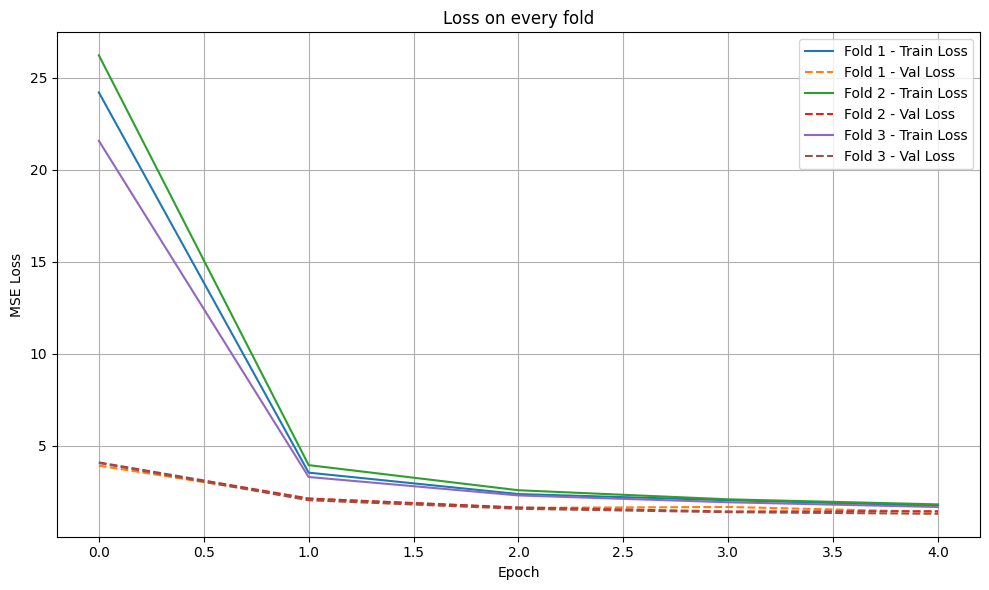

In [ ]:
plt.figure(figsize=(10, 6))
for i, h in enumerate(histories):
    plt.plot(h.history['loss'], label=f"Fold {i+1} - Train Loss")
    plt.plot(h.history['val_loss'], label=f"Fold {i+1} - Val Loss", linestyle='--')

plt.title("Loss on every fold")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

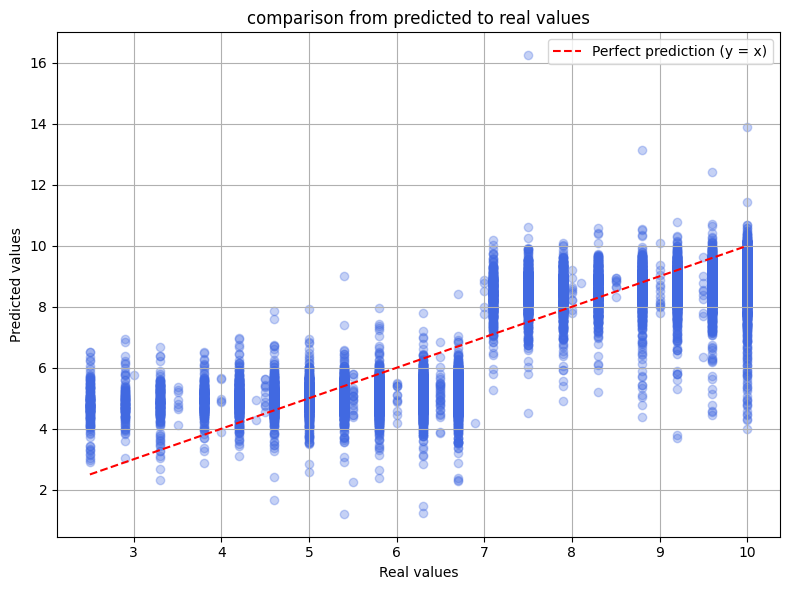

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.3, color='royalblue')
plt.plot([min(all_y_val), max(all_y_val)],
         [min(all_y_val), max(all_y_val)],
         'r--', label='Perfect prediction (y = x)')
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("comparison from predicted to real values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()